In [2]:
!pip install scikit-surprise

### PACKAGES

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import TruncatedSVD
import warnings
import pickle

# Suppress warnings
warnings.filterwarnings("ignore")

### UNDERSTANDING THE DATA

In this project, I will be building a movie recommendation system using collaborative filtering techniques. To get started, I need to load several datasets that contain the necessary information for training and testing the recommendation model.

1. **genome_scores.csv**: This file contains scores for different movie tags, which can help in understanding movie attributes.
2. **genome_tags.csv**: This file provides the tags associated with the movies.
3. **imdb_data.csv**: This file includes additional information about movies from IMDb.
4. **links.csv**: This file links the movie IDs with their corresponding IMDb and TMDb IDs.
5. **tags.csv**: This file includes user-provided tags for movies.
6. **train.csv**: This is the training dataset containing user ratings for different movies.
7. **test.csv**: This is the test dataset for which we need to predict user ratings.
8. **movies.csv**: This file contains basic information about movies, including their titles and genres.

By loading these datasets into Pandas DataFrames, specifically the train.csv, test.scv, and movies.csv, I will be able to manipulate and analyze the data as needed for building the recommendation system.


In [2]:
# Load datasets
genome_scores = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_scores.csv')
genome_tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/genome_tags.csv')
imdb_data = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/imdb_data.csv')
links = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/links.csv')
tags = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/tags.csv')
train = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/train.csv')
test = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/test.csv')
movies = pd.read_csv('/kaggle/input/alx-movie-recommendation-project-2024/movies.csv')

### VIEW THE FIRST FEW ROWS OF THE DATASETS OF INTEREST

To get a better understanding of the structure and contents of the train, test, and movies datasets, I will display the first few rows using the `head()` method. This will help me verify that the data has been loaded correctly and will provide insight into the columns and types of data available.

By examining the initial rows, I can ensure that the datasets contains the expected columns. This will also allow me to observe the format of the ratings provided by users for different movies.


In [3]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [4]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### CHECK FOR ANY MISSING VALUES IN THESE DATASETS

It's important to check for missing values in the datasets to ensure data quality and completeness. Missing values can affect the performance of the recommendation system, so they need to be addressed appropriately.

In this step, I will:
1. **Train Dataset**: Check for missing values in the training dataset to ensure that all user ratings are present.
2. **Test Dataset**: Verify if there are any missing values in the test dataset, which could affect the prediction process.
3. **Movies Dataset**: Examine the movies dataset for any missing information about the movies, such as titles or genres.

By printing the count of missing values for each column in these datasets, I can identify any data cleaning steps that might be necessary before proceeding with the analysis and model building.


In [6]:
print("Missing values in train:")
print(train.isnull().sum())

print("\nMissing values in test:")
print(test.isnull().sum())

print("\nMissing values in movies:")
print(movies.isnull().sum())

Missing values in train:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in test:
userId     0
movieId    0
dtype: int64

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64


### SUMMARY STATISTICS

To gain a deeper understanding of the datasets, I will examine their summary statistics. This will provide insights into the distribution and characteristics of the data, such as central tendencies and variability.

In this step, I will:
1. **Train Dataset**: Print summary statistics to understand the distribution of user ratings, including count, mean, standard deviation, min, max, and quartiles.
2. **Test Dataset**: Check the summary statistics for the test dataset to see the distribution of user and movie IDs.
3. **Movies Dataset**: Analyze the summary statistics for the movies dataset, which will primarily include information about the movie IDs.

By looking at these statistics, I can identify any potential outliers, data skewness, or other anomalies that might need to be addressed before building the recommendation model.


In [7]:
print("Summary statistics for train:")
print(train.describe())

print("\nSummary statistics for test:")
print(test.describe())

print("\nSummary statistics for movies:")
print(movies.describe())

Summary statistics for train:
             userId       movieId        rating     timestamp
count  1.000004e+07  1.000004e+07  1.000004e+07  1.000004e+07
mean   8.119909e+04  2.138911e+04  3.533395e+00  1.215677e+09
std    4.679359e+04  3.919578e+04  1.061124e+00  2.268921e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.197000e+03  3.000000e+00  1.011742e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.199019e+09
75%    1.215790e+05  8.630000e+03  4.000000e+00  1.447242e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09

Summary statistics for test:
             userId       movieId
count  5.000019e+06  5.000019e+06
mean   8.121647e+04  2.136294e+04
std    4.679711e+04  3.918389e+04
min    1.000000e+00  1.000000e+00
25%    4.051850e+04  1.196000e+03
50%    8.094800e+04  2.946000e+03
75%    1.215990e+05  8.622000e+03
max    1.625410e+05  2.091630e+05

Summary statistics for movies:
             movieId
count   62423.000000
me

### Dataset Dimensions

Understanding the size and dimensions of the datasets is crucial for planning the analysis and model building steps. By printing the shape of each dataset, I can see the number of rows and columns they contain, which helps in understanding the scale of the data.

In this step, I will:
1. **Train Dataset**: Print the shape to know the number of user ratings available for training the model.
2. **Test Dataset**: Check the shape to see how many predictions need to be made.
3. **Movies Dataset**: Examine the shape to understand the number of movies available and their associated information.

These dimensions will provide a sense of the dataset sizes and help in managing computational resources effectively.


In [8]:
print("train:")
print(train.shape)

print("\ntest:")
print(test.shape)

print("\nmovies:")
print(movies.shape)

train:
(10000038, 4)

test:
(5000019, 2)

movies:
(62423, 3)


## EXPLORATORY DATA ANALYSIS**

### Dataset Insights

To gain further insights into the training dataset, I will calculate and print some key statistics:

1. **Number of Ratings**: The total number of ratings provided by users.
2. **Number of Unique Movies**: The total number of unique movies that have been rated.
3. **Number of Unique Users**: The total number of unique users who have provided ratings.
4. **Average Number of Ratings per User**: The average number of ratings given by each user.
5. **Average Number of Ratings per Movie**: The average number of ratings received by each movie.

These statistics will help in understanding the distribution of ratings among users and movies, providing a clearer picture of the dataset's structure and characteristics. This information is crucial for designing an effective recommendation model.
**Analyzing and visualizing the dataset**

In [9]:
# Number of ratings
num_ratings = train.shape[0]

# Number of unique movieId's
num_unique_movies = train['movieId'].nunique()

# Number of unique users
num_unique_users = train['userId'].nunique()

# Average number of ratings per user
avg_ratings_per_user = num_ratings / num_unique_users

# Average number of ratings per movie
avg_ratings_per_movie = num_ratings / num_unique_movies

print(f"Number of ratings: {num_ratings}")
print(f"Number of unique movieId's: {num_unique_movies}")
print(f"Number of unique users: {num_unique_users}")
print(f"Average number of ratings per user: {avg_ratings_per_user:.2f}")
print(f"Average number of ratings per movie: {avg_ratings_per_movie:.2f}")

Number of ratings: 10000038
Number of unique movieId's: 48213
Number of unique users: 162541
Average number of ratings per user: 61.52
Average number of ratings per movie: 207.41


### Distribution of Movie Ratings

Visualizing the distribution of movie ratings can provide valuable insights into the data. In this step, I will create a bar plot to display the frequency of each rating in the training dataset.

Using Seaborn's `countplot` function:
- **X-axis**: Represents the ratings given by users.
- **Y-axis**: Represents the count of each rating.

The plot will help to understand the overall distribution of ratings, such as which ratings are most common and if there is any skewness in the data. This understanding is essential for building and evaluating the recommendation model.


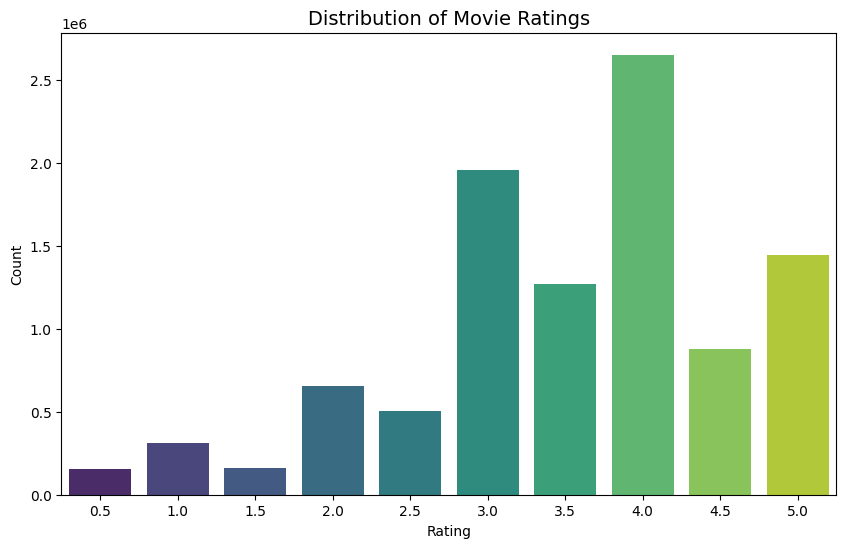

In [10]:
# Plotting the distribution of movie ratings using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x="rating", data=train, palette="viridis")
plt.title("Distribution of Movie Ratings", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Average Ratings Analysis

Understanding the average ratings can provide insights into user behavior and movie popularity. Here, I will calculate and print two important metrics:

1. **Mean Global Rating**: The overall average rating across all users and movies.
2. **Mean Rating per User**: The average rating given by each user, calculated by first averaging ratings per user and then finding the overall mean.

These metrics will help in understanding the general rating tendencies within the dataset. High or low average ratings can influence the design of the recommendation algorithm.


In [11]:
# Mean global rating
mean_global_rating = train['rating'].mean()

# Mean rating per user
mean_rating_per_user = train.groupby('userId')['rating'].mean().mean()

print(f"Mean global rating: {mean_global_rating:.2f}")
print(f"Mean rating per user: {mean_rating_per_user:.2f}")

Mean global rating: 3.53
Mean rating per user: 3.68


### Most Rated Movies

To identify the most popular movies in the dataset, I will merge the `train` dataset with the `movies` dataset on the `movieId` column. This will allow me to access movie titles along with their ratings.

In this step, I will:
1. Merge the `train` dataset with the `movies` dataset to include movie titles.
2. Count the number of ratings for each movie and display the top 10 most rated movies.

This analysis will reveal which movies have received the most attention from users, providing insights into popular movie choices and potential biases in the dataset.


In [12]:
movie_ratings = train.merge(movies, on='movieId')
movie_ratings['title'].value_counts()[0:10]

title
Shawshank Redemption, The (1994)             32831
Forrest Gump (1994)                          32383
Pulp Fiction (1994)                          31697
Silence of the Lambs, The (1991)             29444
Matrix, The (1999)                           29014
Star Wars: Episode IV - A New Hope (1977)    27560
Jurassic Park (1993)                         25518
Schindler's List (1993)                      24004
Braveheart (1995)                            23722
Fight Club (1999)                            23536
Name: count, dtype: int64

### Lowest Rated Movie

In this analysis, I will determine the movie with the lowest average rating among users. To do this, I will:
1. Group the `train` dataset by `movieId` and calculate the mean rating for each movie.
2. Identify the movie with the lowest average rating.
3. Fetch additional information about the lowest rated movie from the `movies` dataset.

This analysis can reveal insights into movies that may have performed poorly in terms of user ratings, which could be due to various factors such as content, genre, or user preferences.

In [13]:
mean_ratings = train.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId']==lowest_rated]

,movieId,title,genres
5645,5757,History of Kim Skov (Historien om Kim Skov) (1...,Documentary|Drama


History of Kim Skov (Historien om Kim Skov) is the lowest rated movie

### Highest Rated Movie

Continuing with the analysis, I will now determine the movie with the highest average rating among users. This involves:
1. Grouping the `train` dataset by `movieId` and calculating the mean rating for each movie.
2. Identifying the movie with the highest average rating.
3. Fetching additional information about the highest rated movie from the `movies` dataset.

Understanding the highest rated movie can provide insights into user preferences and popular movie choices within the dataset.


In [14]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
3141,3234,Train Ride to Hollywood (1975),Comedy|Fantasy|Musical


Train Ride to Hollywood (1975) is the highest rated movie

### User Ratings for the Highest Rated Movie

To further analyze the highest rated movie, I will retrieve the user ratings specifically for that movie from the `train` dataset. This involves:
1. Filtering the `train` dataset to include only rows where the `movieId` matches the ID of the highest rated movie.
2. Displaying the user ratings for the highest rated movie.

This analysis will provide a detailed view of how users have rated the highest rated movie, allowing for deeper insights into user preferences and sentiments towards this particular movie.


In [15]:
train[train['movieId'] == highest_rated]

,userId,movieId,rating,timestamp
3913468,124635,3234,5.0,1047315411


### Analysis of "Train Ride to Hollywood (1975)"

In this analysis, I will focus on the movie "Train Ride to Hollywood (1975)" which is the highest rated movie to understand its ratings within the dataset. This involves:
1. Finding the `movieId` corresponding to "Train Ride to Hollywood (1975)" in the `movies` dataset.
2. Filtering the `train` dataset to include only ratings for the movie "Train Ride to Hollywood (1975)" using its `movieId`.
3. Counting the number of ratings received by "Train Ride to Hollywood (1975)".

This analysis will provide insights into the popularity and user engagement with the specific movie "Train Ride to Hollywood (1975)" within the dataset.


In [16]:
# Find the movieId of "Train Ride to Hollywood (1975)"
movie_id_train_ride = movies[movies['title'] == 'Train Ride to Hollywood (1975)']['movieId'].iloc[0]

# Filter the train DataFrame for ratings of the movie "Train Ride to Hollywood (1975)"
ratings_train_ride = train[train['movieId'] == movie_id_train_ride]

# Get the number of ratings for "Train Ride to Hollywood (1975)"
num_ratings_train_ride = ratings_train_ride.shape[0]

print(f"Number of ratings for 'Train Ride to Hollywood (1975)': {num_ratings_train_ride}")

Number of ratings for 'Train Ride to Hollywood (1975)': 1


Train Ride to Hollywood (1975) may be the highest rated movie but it only has 1 rating. The best way to evaluate movie popularity is by looking at the bayesian average

### Calculating Bayesian Average Ratings for Movies

In this analysis, I will calculate the Bayesian average ratings for movies to evaluate their popularity more accurately. The process involves:

1. **Calculating movie statistics** such as count (number of ratings) and mean rating.
2. **Determining the parameters C and m** for the Bayesian average calculation. 

   - `C`: The average number of ratings for a given movie.
   - `m`: The average rating for a given movie.

3. **Defining the Bayesian average formula**:

   \[
   \text{Bayesian Average} = \frac{{C \cdot m + \sum \text{Ratings}}}{{C + \text{Number of Ratings}}}
   \]

   - `C * m`: Represents the prior information based on the average rating and number of ratings for a movie.
   - `Sum of Ratings`: The sum of all ratings given to the movie.
   - `C + Number of Ratings`: Represents the total weight, incorporating both prior information and actual ratings.

4. **Applying the Bayesian average formula** (`bayesian_avg`) to calculate Bayesian average ratings for each movie.
5. **Merging the Bayesian average ratings with movie titles** for better interpretation.
6. **Sorting the movies** based on their Bayesian average ratings in descending order.

The Bayesian average rating provides a more robust measure of movie popularity by considering both the average rating and the number of ratings. Movies with fewer ratings will have their ratings adjusted towards the overall average, reducing potential biases from sparse data. This approach helps in identifying top-rated movies more accurately within the dataset.


In [17]:
# Calculate movie statistics: count and mean rating
movie_stats = train.groupby('movieId')['rating'].agg(['count', 'mean'])

# Calculate C and m for Bayesian average
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

# Define the Bayesian average function
def bayesian_avg(ratings):
    bayesian_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return round(bayesian_avg, 3)

# Calculate Bayesian average ratings for all movies
bayesian_avg_ratings = train.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

# Merge Bayesian average ratings with movie titles
bayesian_avg_ratings = bayesian_avg_ratings.merge(movies[['movieId', 'title']], on='movieId')

# Sort movies by Bayesian average rating in descending order
sorted_movies = bayesian_avg_ratings.sort_values('bayesian_avg', ascending=False)

# Display the top-rated movies based on Bayesian average
print(sorted_movies.head())

Average number of ratings for a given movie: 207.41
Average rating for a given movie: 3.10
      movieId  bayesian_avg                             title
314       318         4.409  Shawshank Redemption, The (1994)
840       858         4.299             Godfather, The (1972)
49         50         4.267        Usual Suspects, The (1995)
1190     1221         4.256    Godfather: Part II, The (1974)
522       527         4.238           Schindler's List (1993)


Using the Bayesian average, we see that Shawshank Redemption, The Godfather, and The Usual Suspects are the most highly rated movies.

### Sorting Movies by Bayesian Average Rating

In this step, I will sort the movies based on their Bayesian average rating in ascending order. This involves:

1. Using the `sort_values` method on the `bayesian_avg_ratings` DataFrame to sort the movies by their Bayesian average rating.
2. Sorting in ascending order to display the lowest-rated movies first.

Let's proceed with sorting the movies and displaying the lowest-rated movies based on their Bayesian average.


In [18]:
# Sort movies by Bayesian average rating in ascending order
sorted_movies = bayesian_avg_ratings.sort_values('bayesian_avg', ascending=True)

# Display the lowest-rated movies based on Bayesian average
print(sorted_movies.head())

       movieId  bayesian_avg                           title
3493      3593         1.741        Battlefield Earth (2000)
11310    50798         1.958               Epic Movie (2007)
6457      6587         1.966                    Gigli (2003)
1688      1760         2.012              Spice World (1997)
1501      1556         2.014  Speed 2: Cruise Control (1997)


Taking the Bayesian averaging into consideration, it looks like Speed 2: Cruise Control, Spice World, and Gigli are the worst rated movies. Gypsy isn't so bad after all.

### MOVIE GENRES

Preprocess the movie dataset
- Genres: movie genres are expressed as a string with a pipe | separating each genre. manipulate this string into a list.
- title: currently has (year) appended at the end. Extract year from each title string and create a new column for it.

### Preprocessing Movie Genres

In this step, I am preprocessing the movie genres data by splitting the genres column on the "|" delimiter. This involves:

1. Using the `apply` method along with a lambda function to split each genre entry in the 'genres' column into a list of genres.
2. Assigning the modified 'genres' column back to the DataFrame.

This preprocessing step will allow us to work with individual genres more easily for analysis or further processing.


In [19]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Counting Genre Frequencies
#### How many genres do we have

In this step, I am using the `Counter` from the `collections` module to count the frequency of each genre in the 'genres' column of the movies DataFrame. This involves:

1. Creating a Counter object `genre_frequency` by iterating through each genre in the 'genres' column using a nested loop.
2. Counting the occurrences of each genre and storing the results in the `genre_frequency` Counter.

After counting the genre frequencies, I will display the total number of unique genres and the frequency of each genre in the dataset.


In [20]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 25606,
         'Comedy': 16870,
         'Thriller': 8654,
         'Romance': 7719,
         'Action': 7348,
         'Horror': 5989,
         'Documentary': 5605,
         'Crime': 5319,
         '(no genres listed)': 5062,
         'Adventure': 4145,
         'Sci-Fi': 3595,
         'Children': 2935,
         'Animation': 2929,
         'Mystery': 2925,
         'Fantasy': 2731,
         'War': 1874,
         'Western': 1399,
         'Musical': 1054,
         'Film-Noir': 353,
         'IMAX': 195})

### Finding the Most Common Genres

In this step, I am using the `most_common` method of the `genre_frequency` Counter to find the 5 most common genres in the dataset. This involves:

1. Using the `most_common` method with an argument of 5 to retrieve the top 5 most common genres along with their frequencies.
2. Printing the result to display the 5 most common genres and their respective frequencies.

This analysis helps identify the most prevalent genres in the dataset, providing insights into the distribution of movie genres.


In [21]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 25606), ('Comedy', 16870), ('Thriller', 8654), ('Romance', 7719), ('Action', 7348)]


The top 5 genres are: Drama, Comedy, Thriller, Romance and Action.

### Extracting Years from Movie Titles

In this step, I am extracting the years from the movie titles in the 'title' column of the movies DataFrame. This involves:

1. Defining a function `extract_year` using regular expressions (`re`) to extract the year from a movie title string in the format "(YYYY)".
2. Applying the `extract_year` function to the 'title' column to create a new 'year' column containing the extracted years as integers.
3. Using a lambda function with `re.sub` to remove the year from the movie title string in the 'title' column.

This preprocessing step helps separate the movie titles and their respective release years, making it easier to analyze movies based on their release dates.

Let's display the first few rows of the DataFrame to verify the changes made.


In [22]:
import re

# Function to extract year from title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

# Apply the function to create a new column 'year'
movies['year'] = movies['title'].apply(extract_year).astype(pd.Int32Dtype())

# Remove the year from the title string
movies['title'] = movies['title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())

# Display the first few rows to verify
print(movies.head())

   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                              genres  year  
0  [Adventure, Animation, Children, Comedy, Fantasy]  1995  
1                     [Adventure, Children, Fantasy]  1995  
2                                  [Comedy, Romance]  1995  
3                           [Comedy, Drama, Romance]  1995  
4                                           [Comedy]  1995  


### Visualizing Genre Frequencies

In this step, I am visualizing the frequency of genres using a bar plot. This involves:

1. Creating a DataFrame `genre_frequency_df` from the genre frequency Counter.
2. Transposing the DataFrame and resetting the index to have columns 'genre' and 'count'.
3. Sorting the DataFrame by the 'count' column in descending order for better visualization.
4. Using Seaborn's `barplot` function to create a bar plot with genres on the x-axis and their frequencies on the y-axis.
5. Rotating the x-axis labels for better readability.

This visualization helps us understand the distribution of genres in the dataset and identify the most common genres based on their frequencies.


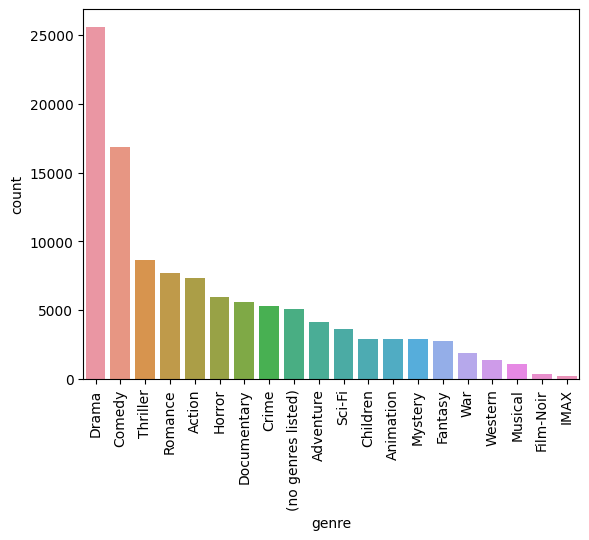

In [23]:
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.show()

### Sampling the Train Dataset

In this step, I am sampling a fraction of the train dataset to reduce its size for faster processing or testing purposes. This involves:

1. Using the `sample` method on the train DataFrame with a sampling fraction of 0.1 (10%) and setting a random state for reproducibility (`random_state=42`).
2. Creating a new DataFrame `sampled_train` containing the sampled data.

The purpose of sampling is to work with a smaller subset of the data while maintaining its statistical properties, which can be useful for preliminary analysis or testing algorithms on a manageable dataset.

Let's check the size of the sampled dataframe to ensure the sampling process was successful.

In [24]:
# Sample the train dataset (e.g., 0.1% of the data)
sampled_train = train.sample(frac=0.1, random_state=42)

# Check the size of the sampled dataframe
print(sampled_train.shape)

(1000004, 4)


### Preparing Data for Surprise Library

In this step, I am preparing the data to be used with the Surprise library, which is commonly used for collaborative filtering and recommendation systems. This involves:

1. Creating a `Reader` object with the rating scale defined as the minimum and maximum ratings in the sampled train dataset (`sampled_train['rating'].min()` and `sampled_train['rating'].max()`).
2. Loading the data into a Surprise `Dataset` object using the `load_from_df` method, with the necessary columns 'userId', 'movieId', and 'rating' from the sampled train dataset.

By preparing the data in this format, we can easily utilize Surprise's algorithms for collaborative filtering and make recommendations based on user-item interactions.

Let's proceed with using the Surprise library for collaborative filtering and recommendation tasks.


In [25]:
# Prepare the data for Surprise library
reader = Reader(rating_scale=(sampled_train['rating'].min(), sampled_train['rating'].max()))
data = Dataset.load_from_df(sampled_train[['userId', 'movieId', 'rating']], reader)

### Defining the Parameter Grid for Grid Search

In this step, I am defining a parameter grid to be used for grid search with the Surprise library. Grid search is a technique used to systematically explore a range of hyperparameters to find the best combination for a machine learning model. This involves:

1. Defining a dictionary `param_grid` containing various hyperparameters and their corresponding values to be explored.
2. The hyperparameters included in the grid are 'n_factors' (number of latent factors), 'n_epochs' (number of epochs), 'lr_all' (learning rate), and 'reg_all' (regularization term).

By defining this parameter grid, we can use grid search to find the optimal combination of hyperparameters for our collaborative filtering model in Surprise.

Let's proceed with grid search using this parameter grid to tune our model and improve its performance.


In [27]:
# Define the parameter grid
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

## Performing Grid Search for Hyperparameter Tuning

In this step, I am performing grid search using the `GridSearchCV` class from the Surprise library. Grid search is a technique used to systematically explore a range of hyperparameters and find the best combination for a machine learning model. This involves:

1. Creating a `GridSearchCV` object `gs` with the following parameters:
   - `SVD`: The algorithm to be tuned (in this case, Singular Value Decomposition for collaborative filtering).
   - `param_grid`: The parameter grid containing hyperparameters to be explored.
   - `measures=['rmse']`: The evaluation metric to optimize, in this case, Root Mean Squared Error (RMSE).
   - `cv=3`: The number of cross-validation folds.
   - `n_jobs=-1`: Utilizing all available CPU cores for parallel processing.

2. Calling the `fit` method on the grid search object `gs` to perform the grid search and find the best hyperparameters based on RMSE.

By performing grid search, we aim to tune the hyperparameters of our collaborative filtering model to improve its predictive performance and accuracy.

Let's proceed with running grid search and optimizing our model's hyperparameters.


In [28]:
# Perform grid search
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

### Retrieving Best Parameters and Best Score from Grid Search

In this step, I am retrieving the best parameters and best score obtained from the grid search performed using the Surprise library. This involves:

1. Accessing the `best_params` attribute of the grid search object `gs` to get the best hyperparameters that resulted in the lowest RMSE (Root Mean Squared Error).
2. Accessing the `best_score` attribute of the grid search object `gs` to get the corresponding best RMSE score achieved during grid search.

After retrieving the best parameters and best score, we can use this information to configure our collaborative filtering model with the optimal hyperparameters for improved performance.

Let's print the best RMSE and best parameters obtained from grid search.


In [29]:
# Get the best parameters and best score
best_params = gs.best_params['rmse']
best_score = gs.best_score['rmse']

print(f"Best RMSE: {best_score}")
print(f"Best parameters: {best_params}")

Best RMSE: 0.9058828083906331
Best parameters: {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


### Training the SVD Model with the Best Parameters

In this step, I am training the Singular Value Decomposition (SVD) model using the best parameters obtained from grid search. This involves:

1. Creating an instance of the SVD algorithm `svd` with the best hyperparameters such as 'n_factors', 'n_epochs', 'lr_all', and 'reg_all'.
2. Splitting the data into training and testing sets using the `train_test_split` function with a test size of 20% and a random state for reproducibility.
3. Fitting the SVD model on the training set `trainset` using the `fit` method.

By training the SVD model with the best parameters, we aim to optimize its performance and accuracy for collaborative filtering and recommendation tasks.

Let's proceed with training the SVD model using the best parameters obtained from grid search.


In [33]:
# Train the SVD model with the best parameters
svd_model = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'], 
          lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
svd_model.fit(trainset)

### Movie Recommendations Function

This function, `get_recommendations`, is designed to provide personalized movie recommendations for a user based on their historical preferences. It leverages the Singular Value Decomposition (SVD) model trained on user-item interactions to estimate how much a user would likely rate a movie they haven't seen yet.

Here's how the function works:

1. It takes three parameters: `user_id` (the ID of the user for whom we want recommendations), `svd_model` (the trained SVD model), and `movies_data` (a DataFrame containing movie data including IDs).

2. For each unique movie in the `movies_data` DataFrame, it predicts the rating that the user with ID `user_id` would give to that movie using the `svd_model.predict` method.

3. The predicted ratings are stored along with their corresponding movie IDs in a list called `user_recommendations`.

4. Finally, the list of recommendations is sorted in descending order based on the estimated ratings, providing the top-rated movies as recommendations for the user.

This function is crucial for enhancing user experience by suggesting relevant and personalized movie choices, thereby improving engagement and satisfaction with the recommendation system.


In [34]:
def get_recommendations(user_id, svd_model, movies_data):
    # Generate recommendations for the user
    user_recommendations = []
    for movie_id in movies_data['movieId'].unique():
        est_rating = svd_model.predict(user_id, movie_id).est
        user_recommendations.append((movie_id, est_rating))

    # Sort recommendations by estimated rating in descending order
    user_recommendations.sort(key=lambda x: x[1], reverse=True)

    return user_recommendations

### Generating Movie Recommendations for Users

I use the `get_recommendations` function to recommend movies for specific users based on their historical preferences. Here's how I do it:

1. First, I define a list of example user IDs (`user_ids_to_recommend`) for whom I want to generate movie recommendations.

2. I loop through each user ID in `user_ids_to_recommend`, calling the `get_recommendations` function with the user ID, the trained SVD model (`svd_model`), and the movie dataset (`movies` DataFrame).

3. For each user, I print the top 10 movie recommendations along with their estimated ratings.

The following code snippet demonstrates how I recommend movies for specific users:

In [35]:
user_ids_to_recommend = [1, 25, 50, 100]

# Loop through each user ID and generate recommendations
for user_id in user_ids_to_recommend:
    recommendations = get_recommendations(user_id, svd_model, movies)
    
    # Print recommendations for each user
    print(f"Recommendations for User {user_id}:")
    for movie_id, est_rating in recommendations[:10]:  # Display top 10 recommendations
        movie_title = movies[movies['movieId'] == movie_id]['title'].values[0]
        print(f"Movie ID: {movie_id} - Title: {movie_title} - Estimated Rating: {est_rating}")
    print('\n')

Recommendations for User 1:
Movie ID: 171011 - Title: Planet Earth II - Estimated Rating: 4.676572904241224
Movie ID: 26578 - Title: Sacrifice, The (Offret - Sacraficatio) - Estimated Rating: 4.601514859156702
Movie ID: 170705 - Title: Band of Brothers - Estimated Rating: 4.525730266245865
Movie ID: 129514 - Title: George Carlin: It's Bad for Ya! - Estimated Rating: 4.520048441730919
Movie ID: 160289 - Title: O.J.: Made in America - Estimated Rating: 4.482237386797499
Movie ID: 170777 - Title: There Once Was a Dog - Estimated Rating: 4.443693681632211
Movie ID: 26471 - Title: Eddie Murphy Delirious - Estimated Rating: 4.425803805951984
Movie ID: 159817 - Title: Planet Earth - Estimated Rating: 4.4068943968623895
Movie ID: 100556 - Title: Act of Killing, The - Estimated Rating: 4.40554311222837
Movie ID: 116136 - Title: Olive Kitteridge - Estimated Rating: 4.396210959885466


Recommendations for User 25:
Movie ID: 171011 - Title: Planet Earth II - Estimated Rating: 4.6343998001040445
Mo

## Evaluating the Model Performance

In this step, I am using the trained SVD model to predict ratings for the validation set (test set) and evaluate its performance using the RMSE (Root Mean Squared Error) metric. This involves:

1. Making predictions on the test set `testset` using the trained SVD model `svd`.
2. Calculating the RMSE by comparing the predicted ratings with the actual ratings in the test set using the `accuracy.rmse` method.

Evaluating the model performance with RMSE helps us assess how well the collaborative filtering model predicts ratings and generalizes to unseen data.

Note: This step is optional and can be used for evaluation purposes to measure the model's accuracy.

Let's proceed with predicting ratings for the validation set and evaluating the model's performance using RMSE.


In [36]:
# Predict ratings for the validation set (optional, for evaluation)
predictions = svd.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9029


0.9028869113000664

### Predicting Ratings for the Test Set

In this step, I am using the trained SVD model `svd` to predict ratings for the test set. This involves:

1. Applying the `predict` method of the SVD model to each row of the test set DataFrame `test`.
2. Using a lambda function to predict the rating for each user-movie pair in the test set based on their userId and movieId.
3. Storing the predicted ratings in a new column 'rating' in the test set DataFrame.

By predicting ratings for the test set, we can generate recommendations and assess the model's performance on unseen data.

Let's proceed with predicting ratings for the test set using the trained SVD model.


In [37]:
# Predict ratings for the test set
test['rating'] = test.apply(lambda x: svd.predict(x['userId'], x['movieId']).est, axis=1)

### Generating the Submission File

In this step, I am generating the submission file in CSV format based on the predicted ratings for the test set. This involves:

1. Creating a new column 'Id' in the test set DataFrame `test` by concatenating the 'userId' and 'movieId' columns with an underscore separator.
2. Using a lambda function with the `apply` method to create the 'Id' column.
3. Creating a new DataFrame `submission` containing only the 'Id' and 'rating' columns from the test set.
4. Saving the submission DataFrame to a CSV file named 'submission.csv' with headers 'Id' and 'rating', and excluding the index column.

By generating the submission file, we can submit our predictions for evaluation or use them in downstream tasks.

Let's proceed with generating the submission file in CSV format.


In [18]:
# Generate the submission file
test['Id'] = test.apply(lambda x: f"{x['userId']}_{x['movieId']}", axis=1)
submission = test[['Id', 'rating']]
submission.to_csv('submission.csv', header=['Id', 'rating'], index=False)

### Reading the Submission File

Reading the 'submission.csv' file into a DataFrame named `submission_df` using pandas `read_csv` function.


In [16]:
submission_df = pd.read_csv("submission.csv")

### Checking Dimensions of Submission File

I am checking the dimensions (number of rows and columns) of the DataFrame `submission_df` using the `.shape` attribute to ensure it has the correct structure as intended.


In [20]:
submission_df.shape

(5000019, 2)

### Viewing the DataFrame

Here i check if the structure of the submission DataFrame `submission_df` using the `.head()` attribute to ensure it is correct by viewing the first few rows of the DataFrame

In [19]:
submission_df.head()

,Id,rating
0,1.0_2011.0,3.659749
1,1.0_4144.0,4.145818
2,1.0_5767.0,3.569102
3,1.0_6711.0,3.857424
4,1.0_7318.0,3.322861
